<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Examples.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

# Examples: Advanced dimensionality reduction techniques
© ExploreAI Academy

In this train, we'll investigate how PCA, MDS and t-SNE dimensionality reduction techniques work on image and text data.

## Learning objectives

By the end of this train, you should be able to;
- Understand advanced dimensionality reduction techniques.
- Implement these techniques on image and text data.

## Outline

In this train we will:
* Explain the following advanced dimensionality reduction techniques:
    * Principal component analysis
    * Multi-dimensional scaling
    * t-SNE
* Implement these techniques on an image dataset.
* Implement these techniques on a text dataset.

## Dimensionality reduction on images
This train will provide a high-level overview of some of the more advanced techniques for dimensionality reduction. We will be using the [handwritten digits data set](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), which is a collection of images of handwritten digits between 0 and 9. The data was generated by a total of 43 people, who wrote a total of 5620 digits by hand which were then digitised and processed into 8x8 greyscale images.

**Note**: Most of the code has been taken directly from [this example code](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#), which contains a few other examples of dimensionality reduction techniques in addition to those expanded on here.

We'll start by importing the necessary packages.

In [1]:
from time import time
import numpy as np
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, preprocessing)
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

### Loading and inspecting the data
The digits dataset is included as part of the `sklearn` library, which means loading it into our notebook is a breeze. For this train, we will simplify things by only looking at the first six digits in the dataset. We can use the `n_class` argument in the `load_digits()` function to select only the numbers from 0 to 5.

In [2]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape

print("Total number of samples: ", n_samples)
print("Features per sample: ", n_features)

Total number of samples:  1083
Features per sample:  64


Below, the image shows a selection from the 64-dimensional digits dataset. Each digit is represented as an 8x8 array of pixels, with values ranging between 0 (white) and 16 (black).  

![digits dataset](https://scikit-learn.org/stable/_images/sphx_glr_plot_lle_digits_001.png)   
Source: [Load digits dataset](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)

The same concept applies to our dataset, only the arrays are a little smaller (8x8) and they have been strung out into single rows of 64 values, ranging between 0 and 16. Let's take a look at the first digit in the data:

In [3]:
X[0,:]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [4]:
# What digit is this?
y[0]

np.int64(0)

Could you tell that the first array was a zero? Unless you are some sort of savant genius, you probably wouldn't be able to tell which digit is represented by looking only at the array values.   

Luckily, we can use the `imshow()` function from the matplotlib library to plot these digits:

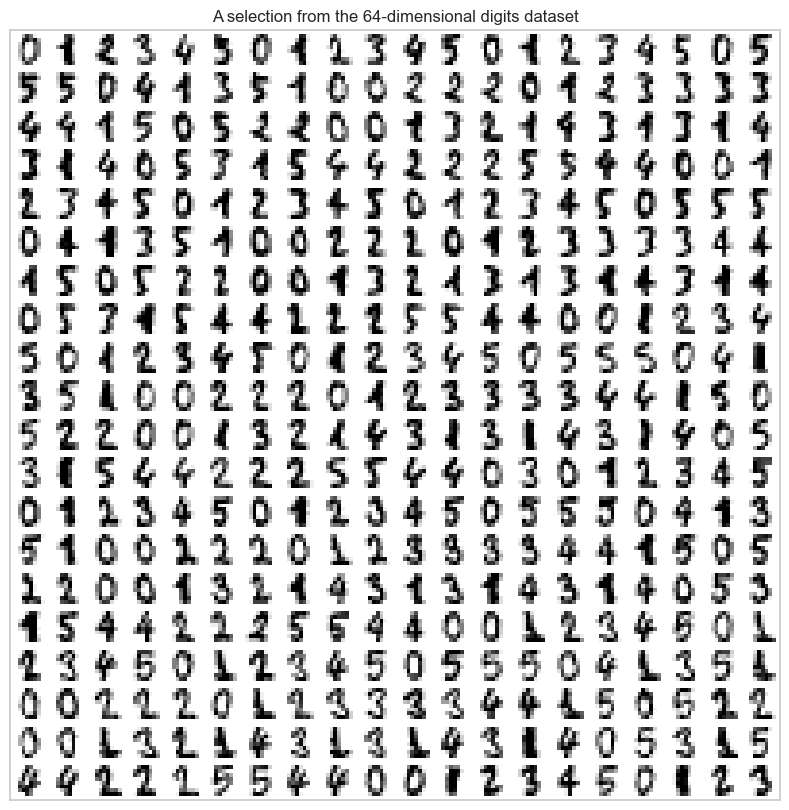

In [5]:
# Plot images of the digits
n_img_per_row = 20

# create a large grid of zeros
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))

# for each column
for i in range(n_img_per_row):
    
    # find the x-coordinate
    ix = 10 * i + 1
    
    # for each row 
    for j in range(n_img_per_row):
        
        # find the y-coordinate
        iy = 10 * j + 1
        
        # change the pixels in this part of the grid to match the digit
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

# plot the grid as a single image
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

### Dimensionality reduction techniques
Now what we are going to try and do is reduce the dimensionality of the entire dataset to just two dimensions (down from 64 dimensions – one per pixel). We will use a few different dimensionality reduction techniques, and at each stage, we will plot the data and see how it is distributed in these two dimensions.   

What is very important to note here is that none of these algorithms will be shown the labels of the data; they will be entirely unsupervised. In each case, we will plot the data in two dimensions, but include the known labels of the data points in the plots for our own validation.   

For plotting, we are going to use the same `plot_embedding()` function defined in the original `sklearn` example code. This does a fantastic job of plotting the digits in a two-dimensional space, so there is no need to reinvent the wheel here.   

**Note:** You will see the word **"embedding"** used in some of the comments and plots below. Simply put, an embedding is a representation of a vector in a different feature space. So in this case, the original digits exist as 64-dimensional arrays and are then reduced to just two dimensions. The resulting two-dimensional vectors are referred to as the embedding vectors.

In [6]:
# Scale and visualise the embedding vectors
def plot_embedding(X, title=None):
    
    # normalise data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    
    ax = plt.subplot(111)
    
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

### Principal component analysis (PCA)
PCA was covered in a previous train, so we won't go into great detail about it here. We know that the objective of PCA is to decompose a dataset into mutually orthogonal components that **each maximise the variance in the dataset**.   

We will use PCA to decompose the dataset into the first two principal components, which will contain the largest and second-largest amounts of variance, respectively.

In [7]:
print("Computing PCA projection")
t0 = time()
X_pca = decomposition.PCA(n_components=2).fit_transform(X)
t1 = time()
print("Finished PCA projection in " + str(t1-t0) + "s.")

Computing PCA projection
Finished PCA projection in 0.018291473388671875s.


Now, before using the awesome `plot_embedding()` function, let's plot the data, without labels, in the first two principal components.

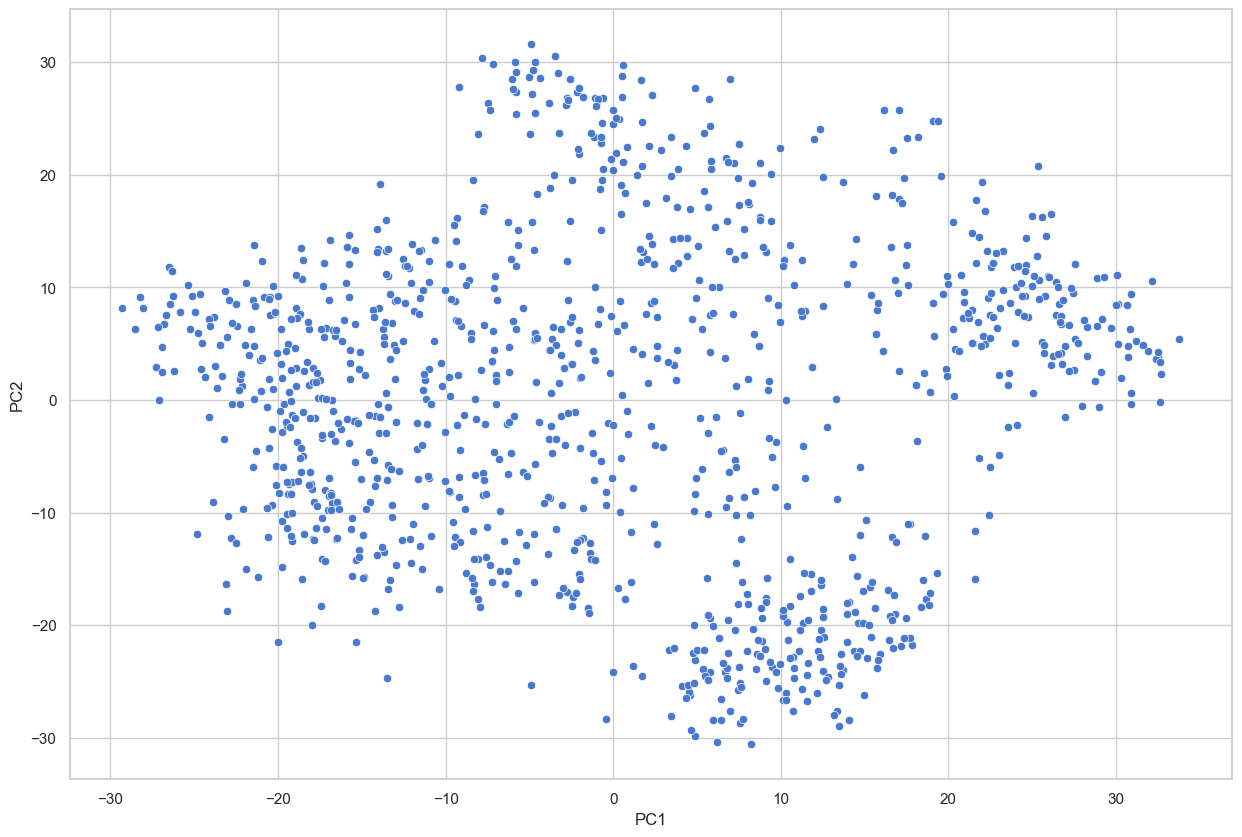

In [8]:
ax = sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                     sizes=(10, 200))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Can you spot any obvious clusters? Perhaps one or two on the right side of the plot?   

Now, let's plot the data with labels:

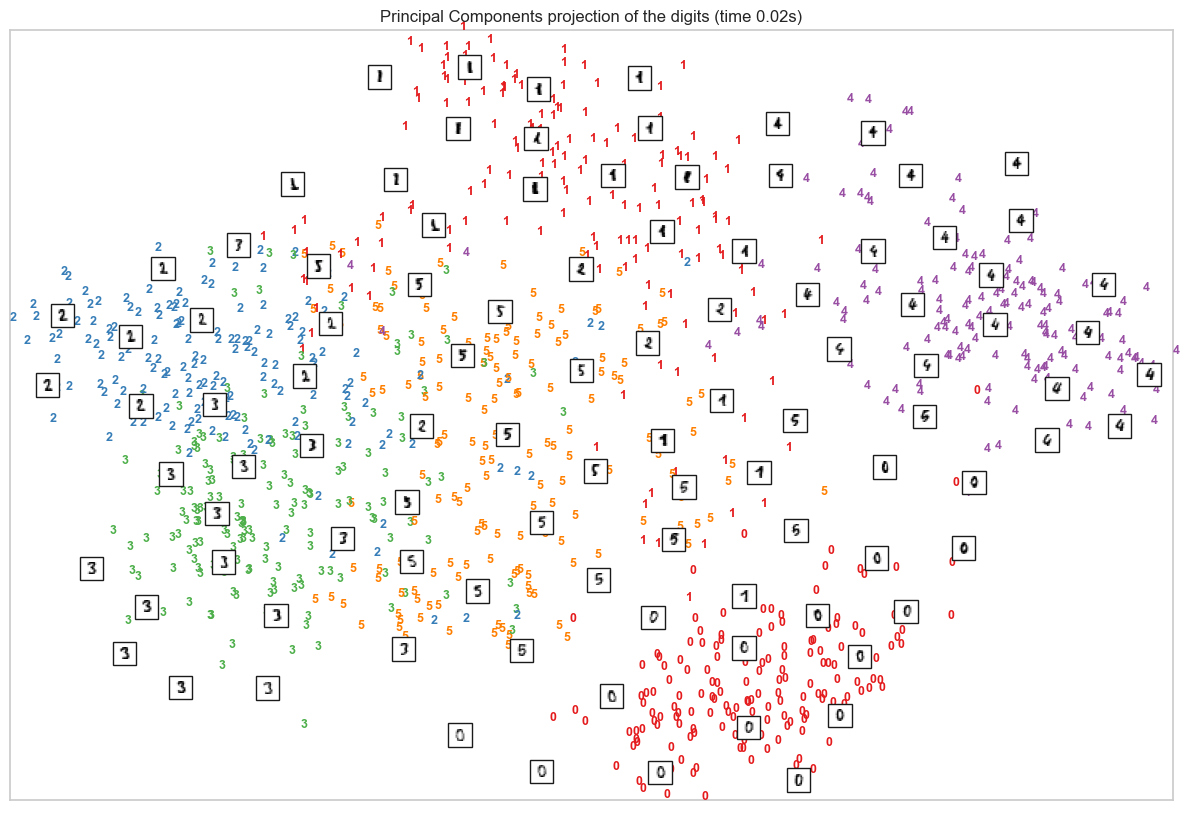

In [9]:
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (t1 - t0))
plt.show()

So we can see that digits do seem to group together, but there isn't the clearest separation between the different digits.   

Now, let's take a look at some other techniques and see how they perform.   

### Multi-dimensional scaling (MDS)
The goal of MDS is to map features to a low-dimensional space **while preserving the distances** between observations in a given dataset.   

MDS can be performed using algorithms that are either *metric* or *non-metric*. Non-metric approaches are typically used to preserve ordinality (order) within data. This is more of a necessity when there are categorical features present in the data. Since the data used here is entirely numeric, we will use a metric approach.   

The **stress** is a measure of the degree to which distances between points in the original feature space correspond with the distances in the low-dimensional space. A lower stress value is preferred, and it is this quantity that is minimised by MDS.

For more information on MDS, read the [`sklearn` user guide](https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling).

In [10]:
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, 
                   n_init=4, 
                   max_iter=200,
                   n_jobs=-1,
                   random_state=42,
                   dissimilarity='euclidean')
t0 = time()
X_mds = clf.fit_transform(X)
t1 = time()
print("Done. Stress: %f" % clf.stress_)

Computing MDS embedding


C:\Users\Eugene\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
C:\Users\Eugene\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(


Done. Stress: 134245920.769475


In [11]:
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (t1 - t0))

### t-distributed stochastic neighbor embedding (t-SNE)
t-SNE is a very complex technique, which can often yield truly stunning results when reducing high-dimensional datasets. Here is a pretty good explanation of t-SNE from [Wikipedia](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding):   
> "The t-SNE algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked, whilst dissimilar points have an extremely small probability of being picked. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimises the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the two distributions with respect to the locations of the points in the map. Note that whilst the original algorithm uses the Euclidean distance between objects as the base of its similarity metric, this should be changed as appropriate."   

Additionally, you can watch the video below for a more detailed explanation of how t-SNE works:

In [12]:
from IPython.display import IFrame

# Youtube
IFrame(width="840", height="472", src="https://www.youtube.com/embed/NEaUSP4YerM")

We won't get into the finer details here. Instead, here is a summary of the important points of t-SNE:   
- Non-linear transformation
- Preserves both local and global structure (usually)
- Computationally expensive

For more information on t-SNE, check out the [`sklearn` user guide](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne) or read through any of the articles below:

- **O'Reilly**: [An illustrated introduction to the t-SNE algorithm](https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm)
- **Analytics Vidhya**: [Comprehensive guide on t-SNE algorithm with implementation in R & Python](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)
- **DataCamp**: [Introduction to t-SNE](https://www.datacamp.com/community/tutorials/introduction-t-sne)
  
Let's fit it to our data.

In [13]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2,
                     perplexity=40,
                     metric='euclidean',
                     init='pca',
                     verbose=1,
                     random_state=42)
t0 = time()
X_tsne = tsne.fit_transform(X)
t1 = time()

Computing t-SNE embedding
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1083 samples in 0.003s...
[t-SNE] Computed neighbors for 1083 samples in 6.320s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1083
[t-SNE] Computed conditional probabilities for sample 1083 / 1083
[t-SNE] Mean sigma: 12.679072
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.632248
[t-SNE] KL divergence after 1000 iterations: 0.538943


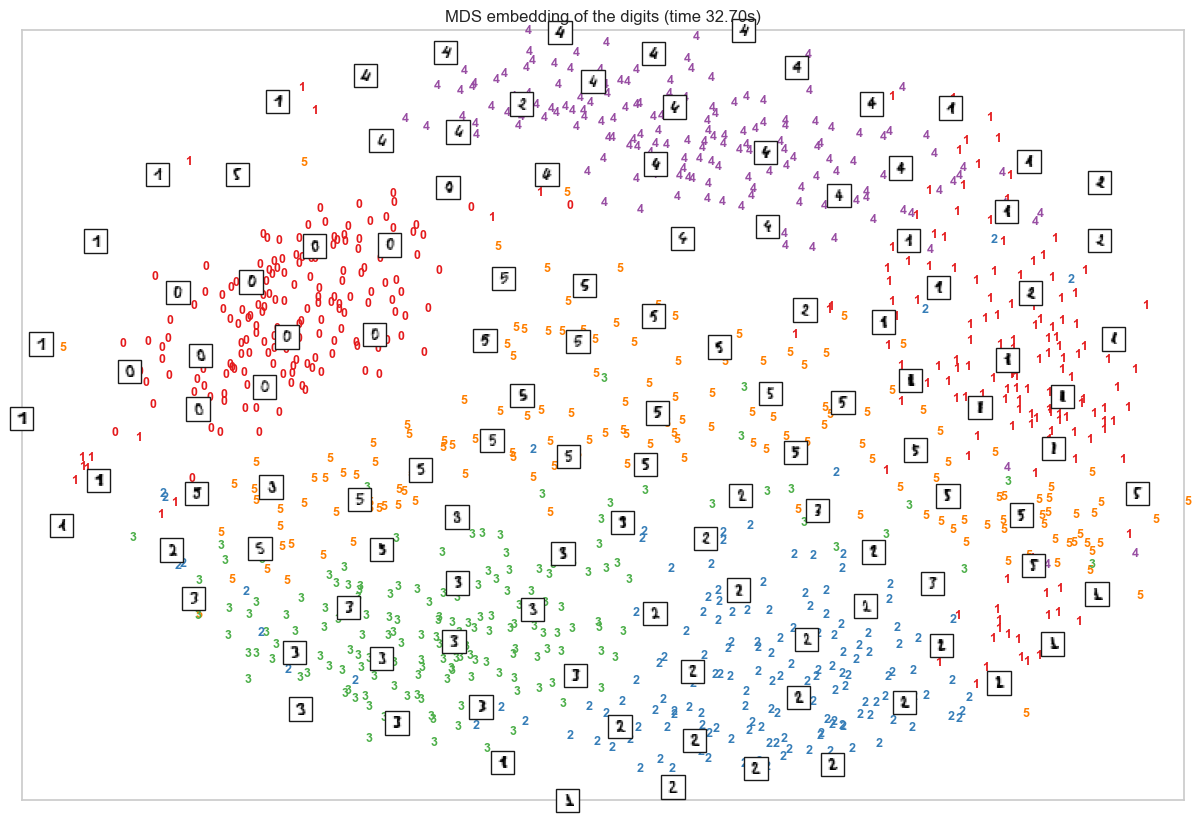

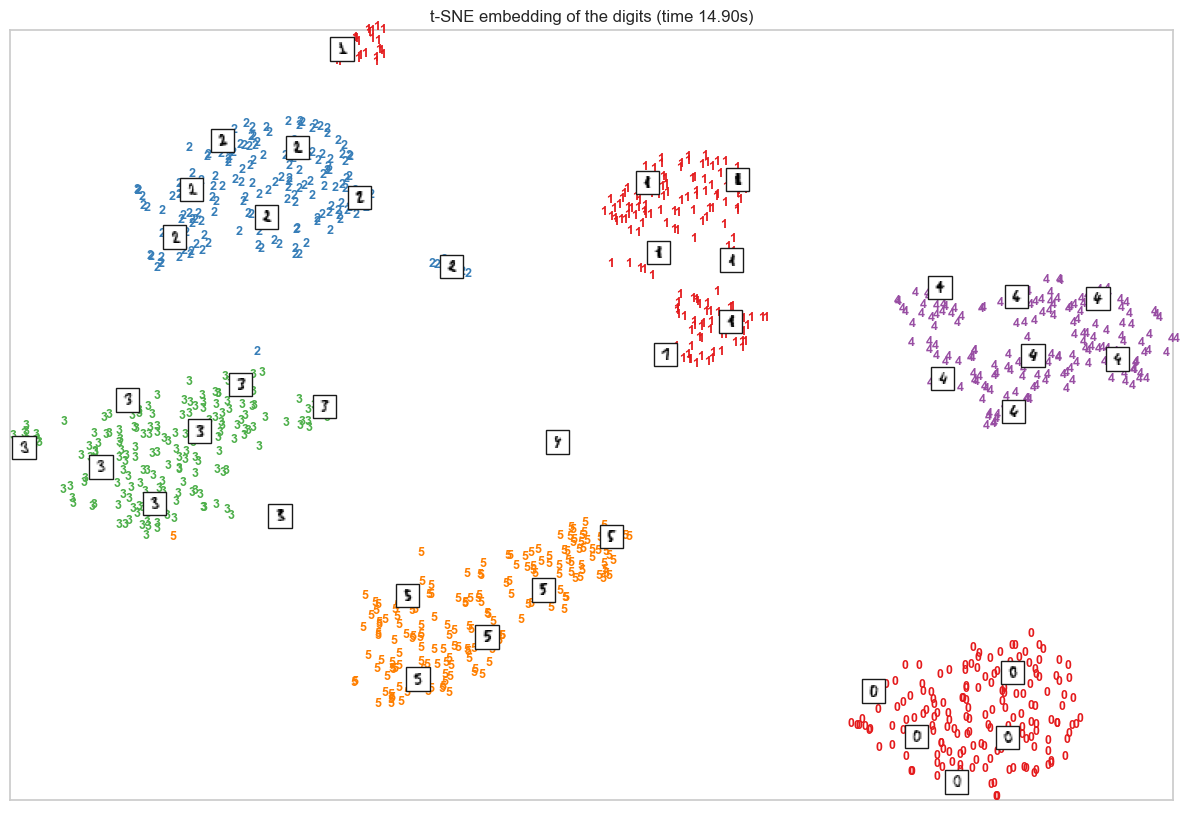

In [14]:
plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (t1 - t0))

plt.show()

Wow, how cool is that?!   

Remember, the algorithm made no use of the labels. The digit arrays were reduced into a two-dimensional space where similar digits ended up close together. We have six main clusters – one for each digit class. But we also have a few smaller clusters – notice the small group of twos that are somewhere between the 1s and the rest of the 2s? Or the 1s that are quite close to the 2s?   

### Word of caution in t-SNE
In this case, we have demonstrated the power of t-SNE as a tool for exploratory data analysis and to reveal natural groups, or clusters, within datasets.   

However, t-SNE can also be very misleading at times and you are encouraged to investigate the effects of the various hyperparameters of the results when working with different datasets.   

Check out [this article](https://distill.pub/2016/misread-tsne/) for some insights into t-SNE's various hyperparameters.

## Dimensionality reduction on text

We'll now work through the same dimensionality reduction techniques again, but this time using text data.

### Loading and inspecting the data
The data we'll be using are Twitter data from @CapeTownFreeway, posted during the year 2017. Let's import the NLP packages we'll need and take a look at the data.

In [ ]:
import pandas as pd
import re

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from collections import Counter

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/unsupervised_sprint/capetownfreeway.csv', encoding='ISO-8859-1')
df.head()

Now for some preprocessing. A few of these columns will not be useful to us going forward, so we will drop them.

In [ ]:
df.drop(['source', 'in_reply_to_screen_name', 'is_retweet'],
        axis=1, inplace=True)

We'll define a function called **clean_tweet** to remove any URLs and any campaign-specific keywords that are frequently repeated in tweets. These tend to create a large amount of noise in the data, which will make the clustering process difficult later on.

In [ ]:
def clean_tweet(tweet):
    no_link_loc = re.sub(r"http\S+", "", tweet)
    no_num_loc = no_link_loc.lower()
    for c in ['inbound','outbound','after','before','update','after','animals','roadworks',':',',',
              '#','@','savewater', 'boozefreeroads','speedkillsfacts','saferoadsforall', 'sharetheroad',
              'alwaysbuckleup', 'boozefreeroad','alwaysbuckleup','savekidslives','.','walksafe']:
        no_num_loc = no_num_loc.replace(c, '')
        
    no_num_loc = no_num_loc.split(',')[0]
    try:
        return no_num_loc
    except:
        pass

In [ ]:
df['clean_tweet'] = df['text'].apply(clean_tweet)
df.head()

To see the effect of cleaning our tweets, we quickly view a wordcloud illustration of the data. You may need to download the required `nltk` resource specified below. If so, uncomment the code and run it before you continue.

In [ ]:
import nltk
# nltk.download('punkt')

In [ ]:
words = []
for i in df.clean_tweet:
    words.extend(word_tokenize(i))
    
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(frequencies = Counter(words))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

As you can see, the ratio of 'delays' to 'cleared' is a clear eyesore for the traffic situation in Cape Town, with clear dominance from the N1 and N2 motorways into the city. 

Before we move on, we need to vectorize our text. Let's do that using  the term frequency–inverse document frequency technique.

### Term frequency–inverse document frequency (tf–idf)
**Term frequency (tf)** measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear far more often in long documents than shorter ones. Thus, the term frequency is often divided by the document length (a.k.a. the total number of terms in the document) as a way of normalisation: 

TF($t$) = (Number of times term $t$ appears in a document) / (Total number of terms in the document).

<i>(This is the relative frequency of each term in a document)</i>

**Inverse document frequency (idf)** measures how important a term is. While computing tf, all terms are considered equally important. However, it is known that certain terms, such as "is", "of", and "that", may appear many times but have little importance. Thus, we need to down-weight the frequent terms while up-weighting the rare ones, by computing the following: 

IDF($t$) = ln(Total number of documents / Number of documents containing term $t$).

**tf–idf** is the product of the values of **tf** and **idf**.


**An example**
> Consider a document containing 100 words wherein the word "cat" appears three times. The term frequency (i.e. tf) for "cat" is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word "cat" appears in one thousand of these. Then, the inverse document frequency (i.e. idf) is calculated as ln(10,000,000 / 1,000) = 4. Thus, the tf–idf weight is the product of these quantities: 0.03 * 4 = 0.12.

More information can be found here: http://www.ultravioletanalytics.com/2016/11/18/tf-idf-basics-with-pandas-scikit-learn/.

Luckily for us, there is a handy `sklearn` package called `TfidfVectorizer` that we can use to choose the number of features we want to keep.

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=50, stop_words='english')
X = vectorizer.fit_transform(df.clean_tweet).toarray()

The tf–idf vectorizer creates a feature set of length 50, with the most frequently used words in the tweets we provided. It takes care of English stopwords such as "in", "on", "the", etc. which carry little to no meaning in terms of the content of the tweet and helps us to remove a large amount of noise.

In [ ]:
vocab = vectorizer.get_feature_names_out()
print(vocab)

In [ ]:
X = pd.DataFrame(X, columns=vocab)
print("n_samples: %d, n_features: %d" % X.shape)

So we are now at a stage where we have tf–idf vectors for each tweet, constructed from the 50 most popular words in the corpus. Let's now implement PCA, MDS, and t-SNE on these vectors.

### Principal component analysis (PCA)
We will use PCA to decompose the dataset into the first two principal components, which will contain the largest and second-largest amounts of variance, respectively.

In [ ]:
scaler = preprocessing.StandardScaler()
pca = decomposition.PCA(n_components=2)

print("Computing PCA projection")
t0 = time()
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
t1 = time()
print("Finished PCA projection in " + str(t1-t0) + "s.")

In [ ]:
ax = sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()
print("The first two principal components explain " + 
      str(np.round(sum(pca.explained_variance_ratio_[:2]),2)*100) + " % of the variance in the data")

In the images example above, we created the function `plot_embedding` to help us visualise what the clusters represent. In this example, let's make it possible for us to view what text each data point portrays.

In [ ]:
import cufflinks as cf
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [ ]:
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['text'] = df['clean_tweet']

In [ ]:
data = [
    go.Scatter(
        x = pca_df.iloc[:2000,0].values,
        y = pca_df.iloc[:2000,1].values,
        text = pca_df.iloc[:2000,2].values,
        hoverinfo = 'text',
        marker = dict(
            color = 'lightblue'
        ),
        mode='markers',
        showlegend = False
    )
]

iplot(data, filename = "add-hover-text")

Hover over the data points to view the text that data point represents. Can you spot any obvious clusters? 

### Multi-dimensional scaling (MDS)

Let's do the same as above, but using MDS.

In [ ]:
from sklearn.manifold import MDS
print("Computing MDS embedding")
mds = manifold.MDS(n_components=2, 
                   n_init=2, 
                   max_iter=200,
                   n_jobs=-1,
                   random_state=42,
                   dissimilarity='euclidean')
t0 = time()
X_mds = mds.fit_transform(X.iloc[:2000,:])
t1 = time()
print("Done. Stress: %f" % mds.stress_)

In [ ]:
mds_df = pd.DataFrame(X_mds, columns=['D1', 'D2'])
mds_df['text'] = df['clean_tweet']

In [ ]:
data = [
    go.Scatter(
        x = mds_df.iloc[:2000,0].values,
        y = mds_df.iloc[:2000,1].values,
        text = mds_df.iloc[:2000,2].values,
        hoverinfo = 'text',
        marker = dict(
            color = 'lightblue'
        ),
        mode='markers',
        showlegend = False
    )
]

iplot(data, filename = "add-hover-text")

There are two important things we note about an MDS scatter plot:

- The axes themselves are meaningless.
- The orientation of the figure is arbitrary.
    
The important thing is the proximity of the points. Since this is a lower-dimensional representation of 'similarity' between points in the higher-dimensional space, it is a useful starting point for clustering and other techniques that look to group points together that share similar characteristics.

### t-distributed stochastic neighbor embedding (t-SNE)

t-SNE often yields truly stunning results when reducing high-dimensional datasets. Let's compute the t-SNE embedding for our text data and see what clusters stand out to us.

In [ ]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2,
                     perplexity=40,
                     metric='euclidean',
                     init='pca',
                     verbose=1,
                     random_state=42)
t0 = time()
X_tsne = tsne.fit_transform(X.iloc[:5000,:])
t1 = time()

In [ ]:
tsne_df = pd.DataFrame(X_tsne, columns=['D1', 'D2'])
tsne_df['text'] = df['clean_tweet']

In [ ]:
data = [
    go.Scatter(
        x = tsne_df.iloc[:2000,0].values,
        y = tsne_df.iloc[:2000,1].values,
        text = tsne_df.iloc[:2000,2].values,
        hoverinfo = 'text',
        marker = dict(
            color = 'lightblue'
        ),
        mode='markers',
        showlegend = False
    )
]

iplot(data, filename = "add-hover-text")

The same comments on MDS regarding orientation and values also apply to t-SNE. It seems that there are already some well-formed clusters in the above representation, suggesting that further investigation needs to be done on the nature of these associations.

Can you determine why some of these clusters were formed? View the text in the clusters and see if you can figure out any similarities.

## Conclusion

This train provided a short recap of PCA and introduced MDS and t-SNE as methods of advanced dimensionality reduction. These concepts were demonstrated using two different datasets: one of images and another of text. You have seen how using these can be effective in reducing the dimensions and thus the computational complexity when working with various forms of data. Now it is up to you to experiment with the above example to gain a further understanding of dimensionality reduction techniques and their uses.

## Additional links

[A beginner’s guide to dimensionality reduction in Machine Learning](https://towardsdatascience.com/dimensionality-reduction-for-machine-learning-80a46c2ebb7e)

[Introduction to Dimensionality Reduction for Machine Learning](https://machinelearningmastery.com/dimensionality-reduction-for-machine-learning/)

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>